# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [6]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

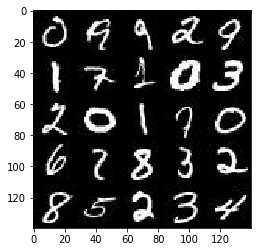

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

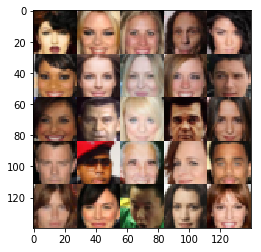

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [67]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    LR = tf.placeholder(tf.float32, name='learn_rate')
    return (real_input, z_data, LR)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [68]:
alpha = 0.2
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        outputs = tf.sigmoid(logits)
        
        return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [97]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1,7,7,256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [98]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [99]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
            g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [100]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [101]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.0807... Generator Loss: 3.1586
Epoch 0/2... Discriminator Loss: 0.0640... Generator Loss: 3.4009
Epoch 0/2... Discriminator Loss: 0.0725... Generator Loss: 4.4350
Epoch 0/2... Discriminator Loss: 0.5425... Generator Loss: 4.1320


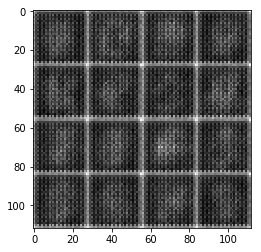

Epoch 0/2... Discriminator Loss: 1.2426... Generator Loss: 0.5886
Epoch 0/2... Discriminator Loss: 1.4744... Generator Loss: 0.5367
Epoch 0/2... Discriminator Loss: 1.6050... Generator Loss: 1.1925
Epoch 0/2... Discriminator Loss: 0.9716... Generator Loss: 0.9657
Epoch 0/2... Discriminator Loss: 0.9819... Generator Loss: 1.0038


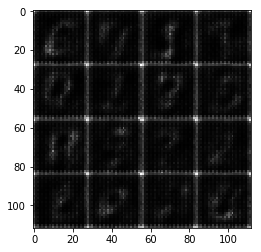

Epoch 0/2... Discriminator Loss: 0.9449... Generator Loss: 1.5523
Epoch 0/2... Discriminator Loss: 0.8379... Generator Loss: 1.7841
Epoch 0/2... Discriminator Loss: 1.3428... Generator Loss: 2.5017
Epoch 0/2... Discriminator Loss: 0.9870... Generator Loss: 1.4980
Epoch 0/2... Discriminator Loss: 0.9028... Generator Loss: 0.8986


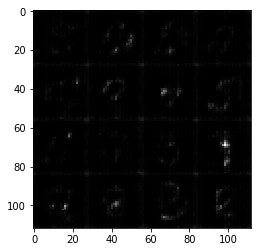

Epoch 0/2... Discriminator Loss: 0.9385... Generator Loss: 1.4447
Epoch 0/2... Discriminator Loss: 0.9777... Generator Loss: 1.1971
Epoch 0/2... Discriminator Loss: 1.1368... Generator Loss: 2.2410
Epoch 0/2... Discriminator Loss: 0.9394... Generator Loss: 0.8248
Epoch 0/2... Discriminator Loss: 0.7556... Generator Loss: 1.2986


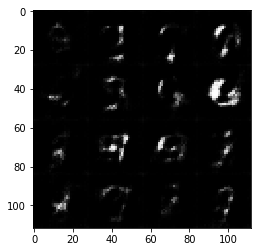

Epoch 0/2... Discriminator Loss: 1.1652... Generator Loss: 2.4731
Epoch 0/2... Discriminator Loss: 0.7705... Generator Loss: 0.9786
Epoch 0/2... Discriminator Loss: 0.7918... Generator Loss: 1.1375
Epoch 0/2... Discriminator Loss: 0.8206... Generator Loss: 2.2600
Epoch 0/2... Discriminator Loss: 0.7881... Generator Loss: 2.2953


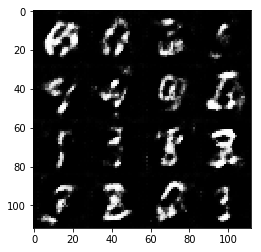

Epoch 0/2... Discriminator Loss: 0.7707... Generator Loss: 0.9255
Epoch 0/2... Discriminator Loss: 0.6204... Generator Loss: 1.3776
Epoch 0/2... Discriminator Loss: 1.1604... Generator Loss: 2.9121
Epoch 0/2... Discriminator Loss: 0.9124... Generator Loss: 0.7154
Epoch 0/2... Discriminator Loss: 0.5597... Generator Loss: 1.5226


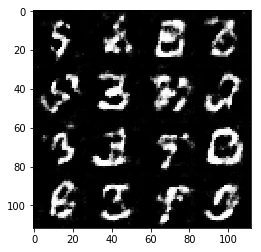

Epoch 0/2... Discriminator Loss: 0.8032... Generator Loss: 0.9586
Epoch 0/2... Discriminator Loss: 0.6072... Generator Loss: 2.1065
Epoch 0/2... Discriminator Loss: 0.9671... Generator Loss: 2.7969
Epoch 0/2... Discriminator Loss: 0.7854... Generator Loss: 0.8872
Epoch 0/2... Discriminator Loss: 1.3668... Generator Loss: 0.3989


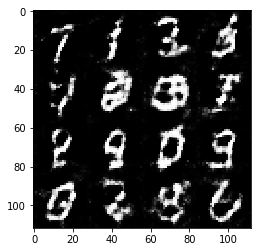

Epoch 0/2... Discriminator Loss: 0.7401... Generator Loss: 1.3546
Epoch 0/2... Discriminator Loss: 1.0523... Generator Loss: 0.6191
Epoch 0/2... Discriminator Loss: 0.7909... Generator Loss: 1.0904
Epoch 0/2... Discriminator Loss: 1.0198... Generator Loss: 1.6229
Epoch 0/2... Discriminator Loss: 0.6943... Generator Loss: 1.2676


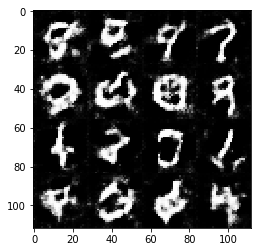

Epoch 0/2... Discriminator Loss: 0.8060... Generator Loss: 1.1806
Epoch 0/2... Discriminator Loss: 0.9595... Generator Loss: 0.7444
Epoch 0/2... Discriminator Loss: 1.2260... Generator Loss: 2.5642
Epoch 0/2... Discriminator Loss: 1.0447... Generator Loss: 2.1968
Epoch 0/2... Discriminator Loss: 0.7631... Generator Loss: 1.5795


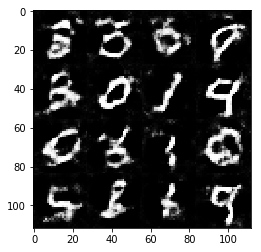

Epoch 0/2... Discriminator Loss: 0.9559... Generator Loss: 0.7396
Epoch 0/2... Discriminator Loss: 0.7460... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.9232
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 0.9967
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 1.4397


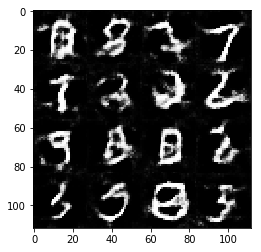

Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.5016
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 1.8315
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 0.7127
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 0.7038


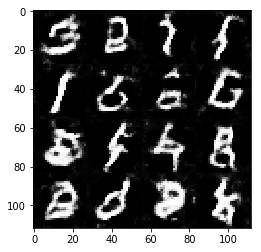

Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.2603
Epoch 1/2... Discriminator Loss: 0.9232... Generator Loss: 2.0846
Epoch 1/2... Discriminator Loss: 0.7805... Generator Loss: 1.1296
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 0.7966


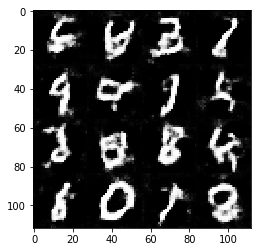

Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 2.2680
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 1.3103
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 0.8465


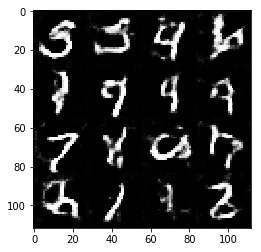

Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.3908
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 1.7212
Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 1.0683


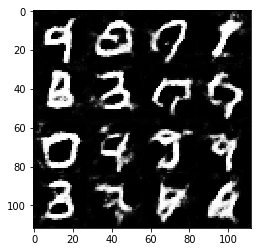

Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.3137
Epoch 1/2... Discriminator Loss: 0.7636... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 1.0706
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 1.7954
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 2.6118


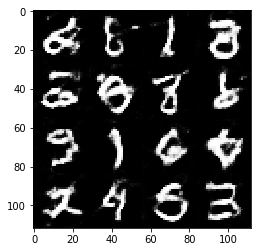

Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 1.4058
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.0607
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.9853
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.0637
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 1.5266


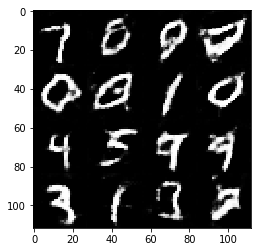

Epoch 1/2... Discriminator Loss: 0.8045... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 0.6762... Generator Loss: 1.7573
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 0.9248
Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 1.1310
Epoch 1/2... Discriminator Loss: 0.6436... Generator Loss: 1.3332


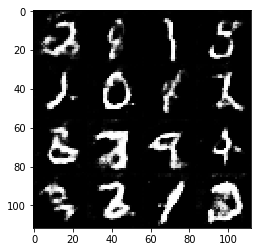

Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.0469
Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 1.2739
Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 0.6820
Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 0.6641


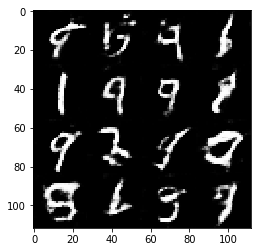

Epoch 1/2... Discriminator Loss: 0.6057... Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 0.8806


In [102]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.4705... Generator Loss: 1.4107
Epoch 0/1... Discriminator Loss: 0.4516... Generator Loss: 1.5604
Epoch 0/1... Discriminator Loss: 1.6260... Generator Loss: 0.2895
Epoch 0/1... Discriminator Loss: 0.4552... Generator Loss: 1.5871


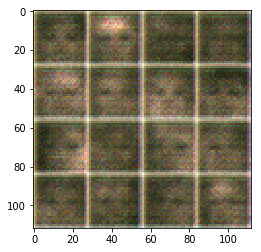

Epoch 0/1... Discriminator Loss: 0.5292... Generator Loss: 1.8714
Epoch 0/1... Discriminator Loss: 0.5703... Generator Loss: 3.1037
Epoch 0/1... Discriminator Loss: 0.8416... Generator Loss: 1.0101
Epoch 0/1... Discriminator Loss: 0.4712... Generator Loss: 3.1008
Epoch 0/1... Discriminator Loss: 0.4316... Generator Loss: 2.0965


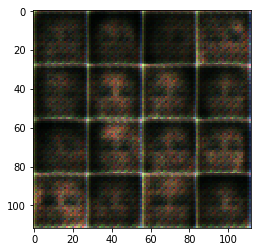

Epoch 0/1... Discriminator Loss: 0.9531... Generator Loss: 0.7982
Epoch 0/1... Discriminator Loss: 0.6501... Generator Loss: 1.3608
Epoch 0/1... Discriminator Loss: 0.5140... Generator Loss: 1.4321
Epoch 0/1... Discriminator Loss: 0.3835... Generator Loss: 2.4475
Epoch 0/1... Discriminator Loss: 0.4696... Generator Loss: 1.7344


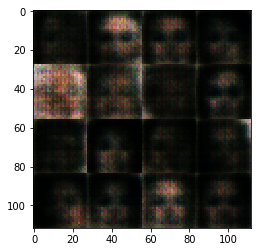

Epoch 0/1... Discriminator Loss: 0.7415... Generator Loss: 1.3774
Epoch 0/1... Discriminator Loss: 1.0916... Generator Loss: 0.6489
Epoch 0/1... Discriminator Loss: 1.0974... Generator Loss: 0.5621
Epoch 0/1... Discriminator Loss: 0.5845... Generator Loss: 1.2784
Epoch 0/1... Discriminator Loss: 1.4494... Generator Loss: 0.4286


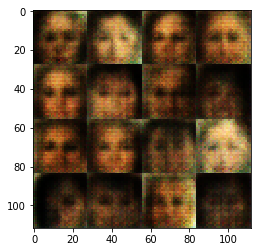

Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 0.7140
Epoch 0/1... Discriminator Loss: 0.7277... Generator Loss: 1.1772
Epoch 0/1... Discriminator Loss: 0.3288... Generator Loss: 1.8125
Epoch 0/1... Discriminator Loss: 1.3205... Generator Loss: 0.5564
Epoch 0/1... Discriminator Loss: 0.4940... Generator Loss: 1.8087


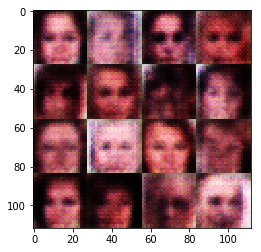

Epoch 0/1... Discriminator Loss: 1.1594... Generator Loss: 0.5381
Epoch 0/1... Discriminator Loss: 0.3316... Generator Loss: 2.3541
Epoch 0/1... Discriminator Loss: 0.8609... Generator Loss: 0.9622
Epoch 0/1... Discriminator Loss: 1.3180... Generator Loss: 0.5375
Epoch 0/1... Discriminator Loss: 1.2497... Generator Loss: 0.5184


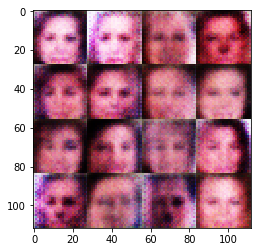

Epoch 0/1... Discriminator Loss: 1.2023... Generator Loss: 0.5790
Epoch 0/1... Discriminator Loss: 0.9658... Generator Loss: 0.9137
Epoch 0/1... Discriminator Loss: 0.9719... Generator Loss: 2.3857
Epoch 0/1... Discriminator Loss: 1.2117... Generator Loss: 2.1137
Epoch 0/1... Discriminator Loss: 1.5259... Generator Loss: 2.0992


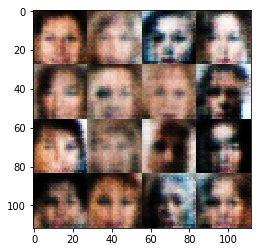

Epoch 0/1... Discriminator Loss: 1.3584... Generator Loss: 0.5707
Epoch 0/1... Discriminator Loss: 2.0236... Generator Loss: 3.0649
Epoch 0/1... Discriminator Loss: 0.7489... Generator Loss: 1.6148
Epoch 0/1... Discriminator Loss: 0.9625... Generator Loss: 0.9864
Epoch 0/1... Discriminator Loss: 0.7900... Generator Loss: 1.9700


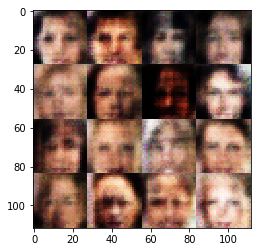

Epoch 0/1... Discriminator Loss: 1.7351... Generator Loss: 0.2942
Epoch 0/1... Discriminator Loss: 1.2493... Generator Loss: 0.5866
Epoch 0/1... Discriminator Loss: 1.1799... Generator Loss: 0.6306
Epoch 0/1... Discriminator Loss: 0.7788... Generator Loss: 1.9507
Epoch 0/1... Discriminator Loss: 0.6265... Generator Loss: 1.1602


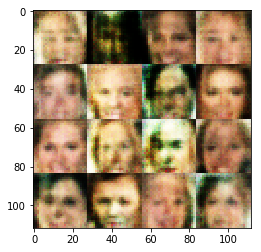

Epoch 0/1... Discriminator Loss: 1.7225... Generator Loss: 0.2930
Epoch 0/1... Discriminator Loss: 2.0815... Generator Loss: 0.2275
Epoch 0/1... Discriminator Loss: 0.5436... Generator Loss: 1.6122
Epoch 0/1... Discriminator Loss: 0.9761... Generator Loss: 0.9591
Epoch 0/1... Discriminator Loss: 0.8195... Generator Loss: 2.0432


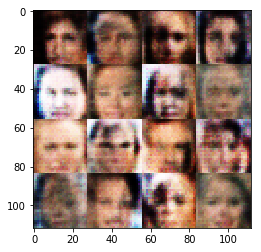

Epoch 0/1... Discriminator Loss: 0.4338... Generator Loss: 4.0853
Epoch 0/1... Discriminator Loss: 1.1454... Generator Loss: 5.3940
Epoch 0/1... Discriminator Loss: 0.4699... Generator Loss: 2.3691
Epoch 0/1... Discriminator Loss: 0.4898... Generator Loss: 1.4016
Epoch 0/1... Discriminator Loss: 0.6606... Generator Loss: 1.0530


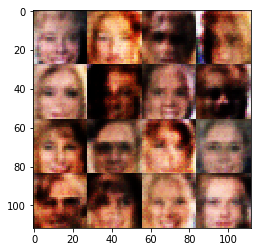

Epoch 0/1... Discriminator Loss: 0.2922... Generator Loss: 3.0472
Epoch 0/1... Discriminator Loss: 0.2794... Generator Loss: 2.2333
Epoch 0/1... Discriminator Loss: 0.6845... Generator Loss: 1.0046
Epoch 0/1... Discriminator Loss: 0.5820... Generator Loss: 4.4596
Epoch 0/1... Discriminator Loss: 0.2717... Generator Loss: 2.1309


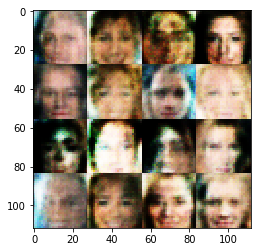

Epoch 0/1... Discriminator Loss: 0.5862... Generator Loss: 4.6509
Epoch 0/1... Discriminator Loss: 0.2493... Generator Loss: 3.9488
Epoch 0/1... Discriminator Loss: 0.1548... Generator Loss: 4.0550
Epoch 0/1... Discriminator Loss: 0.3269... Generator Loss: 1.6560
Epoch 0/1... Discriminator Loss: 0.2393... Generator Loss: 4.1376


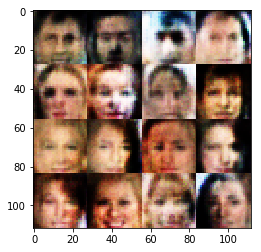

Epoch 0/1... Discriminator Loss: 0.2585... Generator Loss: 3.3759
Epoch 0/1... Discriminator Loss: 0.3433... Generator Loss: 5.3033
Epoch 0/1... Discriminator Loss: 0.2823... Generator Loss: 2.5548
Epoch 0/1... Discriminator Loss: 0.0764... Generator Loss: 4.8067
Epoch 0/1... Discriminator Loss: 1.8581... Generator Loss: 0.2074


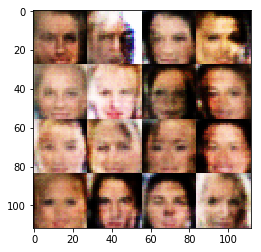

Epoch 0/1... Discriminator Loss: 1.9675... Generator Loss: 6.9568
Epoch 0/1... Discriminator Loss: 0.1721... Generator Loss: 3.6400
Epoch 0/1... Discriminator Loss: 1.0653... Generator Loss: 1.6415
Epoch 0/1... Discriminator Loss: 1.0329... Generator Loss: 0.6094
Epoch 0/1... Discriminator Loss: 0.2746... Generator Loss: 4.1385


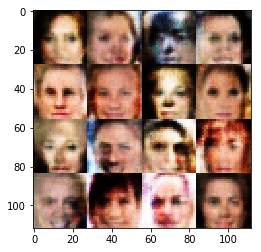

Epoch 0/1... Discriminator Loss: 0.8860... Generator Loss: 2.7563
Epoch 0/1... Discriminator Loss: 0.3973... Generator Loss: 1.3642
Epoch 0/1... Discriminator Loss: 0.1705... Generator Loss: 3.6996
Epoch 0/1... Discriminator Loss: 0.4592... Generator Loss: 1.4183
Epoch 0/1... Discriminator Loss: 1.4801... Generator Loss: 3.4834


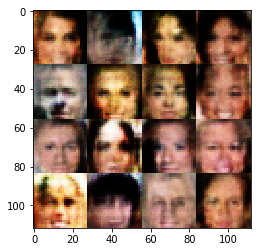

Epoch 0/1... Discriminator Loss: 0.5494... Generator Loss: 1.2141
Epoch 0/1... Discriminator Loss: 0.2812... Generator Loss: 3.8053
Epoch 0/1... Discriminator Loss: 0.6229... Generator Loss: 0.9991
Epoch 0/1... Discriminator Loss: 0.8447... Generator Loss: 0.7717
Epoch 0/1... Discriminator Loss: 0.4735... Generator Loss: 4.3241


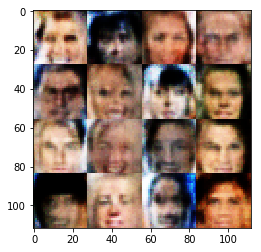

Epoch 0/1... Discriminator Loss: 0.1923... Generator Loss: 4.3538
Epoch 0/1... Discriminator Loss: 0.9899... Generator Loss: 0.6882
Epoch 0/1... Discriminator Loss: 0.2663... Generator Loss: 2.1502
Epoch 0/1... Discriminator Loss: 0.4855... Generator Loss: 1.3765
Epoch 0/1... Discriminator Loss: 0.3113... Generator Loss: 2.0604


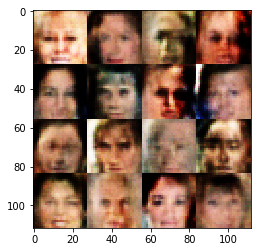

Epoch 0/1... Discriminator Loss: 0.2702... Generator Loss: 2.6838
Epoch 0/1... Discriminator Loss: 0.2492... Generator Loss: 2.1408
Epoch 0/1... Discriminator Loss: 1.2883... Generator Loss: 0.4087
Epoch 0/1... Discriminator Loss: 0.2652... Generator Loss: 3.3124
Epoch 0/1... Discriminator Loss: 0.3054... Generator Loss: 2.2633


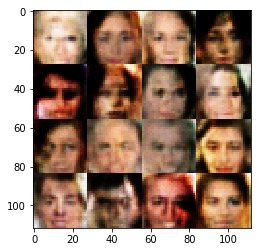

Epoch 0/1... Discriminator Loss: 0.1909... Generator Loss: 2.5451
Epoch 0/1... Discriminator Loss: 0.2143... Generator Loss: 2.5768
Epoch 0/1... Discriminator Loss: 0.4810... Generator Loss: 1.3175
Epoch 0/1... Discriminator Loss: 0.1549... Generator Loss: 4.6630
Epoch 0/1... Discriminator Loss: 0.2056... Generator Loss: 5.7959


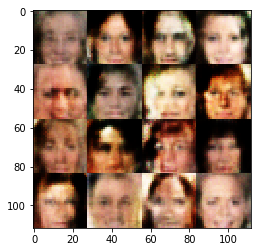

Epoch 0/1... Discriminator Loss: 0.1437... Generator Loss: 3.3022
Epoch 0/1... Discriminator Loss: 0.1062... Generator Loss: 3.4415
Epoch 0/1... Discriminator Loss: 1.1077... Generator Loss: 0.5086
Epoch 0/1... Discriminator Loss: 0.1675... Generator Loss: 3.2022
Epoch 0/1... Discriminator Loss: 0.8050... Generator Loss: 5.9472


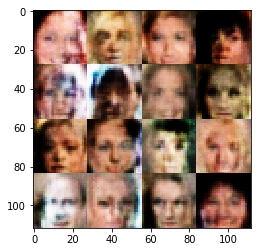

Epoch 0/1... Discriminator Loss: 1.5317... Generator Loss: 0.3030
Epoch 0/1... Discriminator Loss: 0.1834... Generator Loss: 4.1075
Epoch 0/1... Discriminator Loss: 0.3810... Generator Loss: 1.5799
Epoch 0/1... Discriminator Loss: 0.3226... Generator Loss: 2.0009
Epoch 0/1... Discriminator Loss: 0.5203... Generator Loss: 1.3238


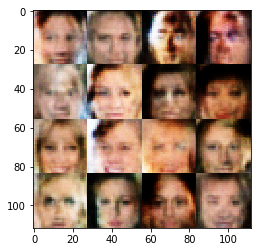

Epoch 0/1... Discriminator Loss: 0.1985... Generator Loss: 2.3155
Epoch 0/1... Discriminator Loss: 0.3398... Generator Loss: 1.7156
Epoch 0/1... Discriminator Loss: 0.4605... Generator Loss: 5.5244
Epoch 0/1... Discriminator Loss: 0.2123... Generator Loss: 2.2239
Epoch 0/1... Discriminator Loss: 0.6564... Generator Loss: 0.9848


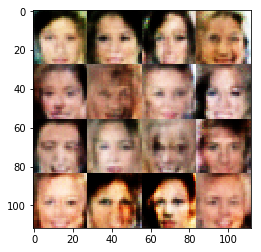

Epoch 0/1... Discriminator Loss: 0.1450... Generator Loss: 3.8124
Epoch 0/1... Discriminator Loss: 0.2905... Generator Loss: 3.1748
Epoch 0/1... Discriminator Loss: 1.2504... Generator Loss: 0.4095
Epoch 0/1... Discriminator Loss: 0.4725... Generator Loss: 4.8608
Epoch 0/1... Discriminator Loss: 0.1835... Generator Loss: 4.0967


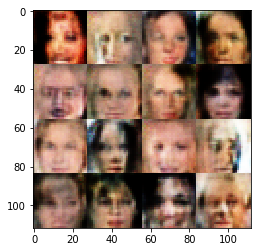

Epoch 0/1... Discriminator Loss: 0.2344... Generator Loss: 5.2551
Epoch 0/1... Discriminator Loss: 0.3085... Generator Loss: 2.7062
Epoch 0/1... Discriminator Loss: 0.1659... Generator Loss: 3.8633
Epoch 0/1... Discriminator Loss: 0.3920... Generator Loss: 1.4237
Epoch 0/1... Discriminator Loss: 0.1813... Generator Loss: 2.8826


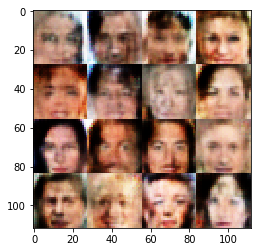

Epoch 0/1... Discriminator Loss: 0.2561... Generator Loss: 2.1203
Epoch 0/1... Discriminator Loss: 0.1796... Generator Loss: 2.3096
Epoch 0/1... Discriminator Loss: 0.4602... Generator Loss: 1.2853
Epoch 0/1... Discriminator Loss: 0.1413... Generator Loss: 2.8938
Epoch 0/1... Discriminator Loss: 0.2241... Generator Loss: 3.4921


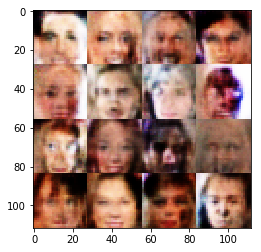

Epoch 0/1... Discriminator Loss: 0.1453... Generator Loss: 2.7075
Epoch 0/1... Discriminator Loss: 0.1643... Generator Loss: 2.8249
Epoch 0/1... Discriminator Loss: 0.7840... Generator Loss: 0.8597
Epoch 0/1... Discriminator Loss: 1.1150... Generator Loss: 0.5498
Epoch 0/1... Discriminator Loss: 0.2867... Generator Loss: 2.0471


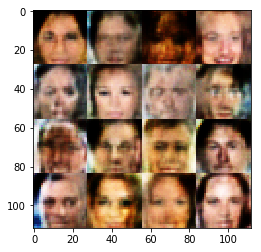

Epoch 0/1... Discriminator Loss: 0.1625... Generator Loss: 2.7652
Epoch 0/1... Discriminator Loss: 0.5929... Generator Loss: 0.9957
Epoch 0/1... Discriminator Loss: 0.3334... Generator Loss: 5.1498
Epoch 0/1... Discriminator Loss: 0.4218... Generator Loss: 4.0938
Epoch 0/1... Discriminator Loss: 0.5592... Generator Loss: 1.1176


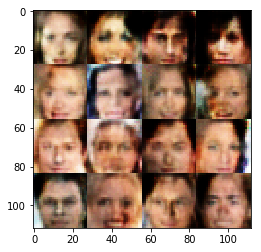

Epoch 0/1... Discriminator Loss: 0.2291... Generator Loss: 2.3106
Epoch 0/1... Discriminator Loss: 0.3239... Generator Loss: 1.8558
Epoch 0/1... Discriminator Loss: 1.7304... Generator Loss: 2.3593
Epoch 0/1... Discriminator Loss: 0.4358... Generator Loss: 2.0086
Epoch 0/1... Discriminator Loss: 0.2908... Generator Loss: 3.4751


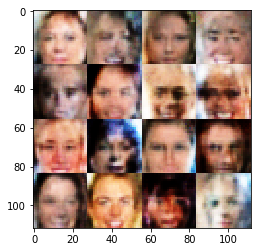

Epoch 0/1... Discriminator Loss: 0.2535... Generator Loss: 2.0388
Epoch 0/1... Discriminator Loss: 0.1441... Generator Loss: 3.0326
Epoch 0/1... Discriminator Loss: 0.3549... Generator Loss: 1.5236
Epoch 0/1... Discriminator Loss: 0.3776... Generator Loss: 1.3930
Epoch 0/1... Discriminator Loss: 0.3546... Generator Loss: 1.6005


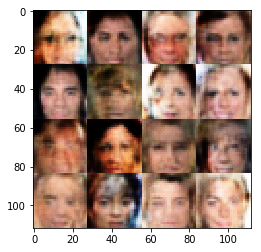

Epoch 0/1... Discriminator Loss: 0.1900... Generator Loss: 4.0837
Epoch 0/1... Discriminator Loss: 0.1787... Generator Loss: 2.9730
Epoch 0/1... Discriminator Loss: 0.2265... Generator Loss: 2.0752
Epoch 0/1... Discriminator Loss: 0.1280... Generator Loss: 3.5885
Epoch 0/1... Discriminator Loss: 0.2396... Generator Loss: 3.5072


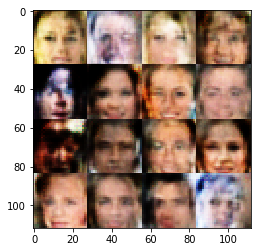

Epoch 0/1... Discriminator Loss: 0.0949... Generator Loss: 4.7970
Epoch 0/1... Discriminator Loss: 0.1017... Generator Loss: 6.1735
Epoch 0/1... Discriminator Loss: 0.4768... Generator Loss: 1.5068
Epoch 0/1... Discriminator Loss: 0.1818... Generator Loss: 2.5901


In [103]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.